# Assignment  week 5 MRS Chap 21

## Notebook made by   (If not filled in correctly: 0 pts for assignment)

__Name(s)__: Adriaan de Vries, Verna Dankers

__Student id(s)__ : 10795227, 10761225

### Pledge (taken from [Coursera's Honor Code](https://www.coursera.org/about/terms/honorcode) )



Put here a selfie with your photo where you hold a signed paper with the following text: (if this is team work, put two selfies here). The link must be to some place on the web, not to a local file. **Assignments without the selfies will not be graded and receive 0 points.**

> My answers to homework, quizzes and exams will be my own work (except for assignments that explicitly permit collaboration).

>I will not make solutions to homework, quizzes or exams available to anyone else. This includes both solutions written by me, as well as any official solutions provided by the course staff.

>I will not engage in any other activities that will dishonestly improve my results or dishonestly improve/hurt the results of others.

<img width=30% src='http://oi63.tinypic.com/2q3srh3.jpg'/>
<img width=30% src="http://i63.tinypic.com/2itj1ic.jpg" border="0">

# Link Analysis



#### Q1 Hits
1. Create the network consisting of the page <http://en.wikipedia.org/wiki/PageRank>, all pages that link to that page (you get those via <http://en.wikipedia.org/wiki/Special:WhatLinksHere/PageRank>), and all outgoing links from <http://en.wikipedia.org/wiki/PageRank>. 

In [1]:
%matplotlib inline

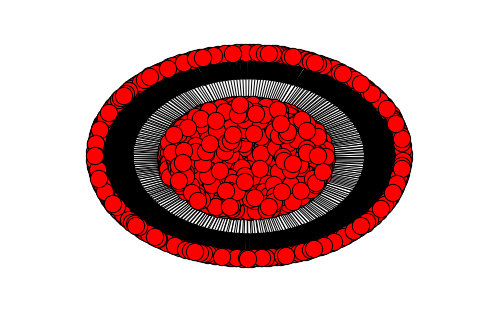

In [18]:
import networkx as nx
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
START_NODE = 'PAGERANKSTARTNODE'

G = nx.DiGraph()
G.add_node(START_NODE)

# filename is for the page with all links towards the PageRank page
f = open('.\Pagerank\outlinks.htm', 'rb')
text = f.read().decode('utf8', 'ignore')
soup = BeautifulSoup(text)
for elem in soup.find_all('li'):
    # not all 'li' elements have a link, try/catch to handle this edge case.
    try:
        link = elem.a.get('href')
        G.add_node(link)
        G.add_edge(link, START_NODE)
    except Exception:
        pass

# filename for the PageRank wikipedia page
f = open('.\Pagerank\PageRank.htm', 'rb')
text = f.read().decode('utf8', 'ignore')
soup = BeautifulSoup(text)
for elem in soup.find_all('a'):
    try:
        link = elem.get('href')
        # cite_notes are also caught, so filtered here
        if str(link)[0:4]=='http':
            G.add_node(link)
            G.add_edge(START_NODE, link)
    except Exception:
        pass

nx.draw(G)
plt.show()

> Note that the graph has so many edges and vertices that any attempt to visualize it results in a jumbled mess.

2. ~~Compute the HITS score for each node in this network.~~
3.   Use the `networkx` package to display the network nicely.

#### Q2 Pagerank and hits

* Do questions Q5,Q6,Q9,Q10 from <http://nbviewer.ipython.org/url/maartenmarx.nl/teaching/zoekmachines/Assignments/ASSIGNMENTS/Week7InformationRetrieval.ipynb>

# Make inverted index

[MakeInvertedIndex](MakeInvertedIndex1516.html): 11  

#### 1 Choose three zones and indicate why these are good and interesting for this data set. Also give weights for each of them. 

- <b>trefwoordlod</b>: this is a good zone to look at, since it indicates the keywords from the file. Users often put such keywords in their queries. If they query terms are inside of these zone, this file is definitely a hit! <b>Weight: 0.45</b>

- <b>citeertitel</b>: this is a good zone to look at, since it summarizes the content of the file in one sentence. If this zone contains a query term, this file is very likely to be a hit! <b>Weight: 0.3</b>

- <b>tekstxml</b>: this is a good zone to look at because this is the body of the file that contains the actual text of the motion. If this zone does not contain a query term or a synonym of a query term, the file is not relevant. <b>Weight: 0.25</b>

#### 2 You want to use TF-IDF weighting for the scoring function of each zone. Think whether you must adjust IDF as well for each zone, or you can just use IDF as before? Argue why your answer is good, possibly using an instructive example.

The original defitions:

$tfidf_{t,d} = tf_{t,d} \cdot idf_{t}$

$idf_{t} = \log(\frac{N}{df_{t}})$ where $N$ is the number of documents in the collection.

When using $tfidf$-weighting for the scoring function of each zone, the $idf$ formula must be adjusted. Why? Let's consider an example. 
Suppose the word ASIELZOEKERSCENTRA only appears in one 'trefwoordlod' in your entire corpus. When your query term contains ASIELZOEKERSCENTRA, that file is a hit! The fact that the word is in the 'trefwoordlod' zone is very important, since that zone is an important zone, since it contains the keywords from the file. But if ASIELZOEKERSCENTRA appears in many documents inside the 'tekstxml' zone, the idf weight for ASIELZOEKERSCENTRA in the 'trefwoordlod' zone will still be very very low. We do not want that, because the fact that ASIELZOEKERSCENTRA is in the 'trefwoordlod' zone still really distinguishes that file from all of the other files, when looking at the 'trefwoordlod' zone. So we want the idf weight for ASIELZOEKERSCENTRA in the 'trefwoordlod' to be high. Therefore it is a better idea to consider only the 'trefwoordlod' zone frequency when calculating that idf weight for that zone. So we would adapt the $idf$ formula:

$idf_{t,z} = \log(\frac{N}{df_{t,z}})$ where $z$ indicates which zone to look at. So we do not use the regular document frequency, but the frequency of term t in all zones $z$.

#### 3 Design an index for your 3 zones and an algorithm which computes score(q,d) based on the linear weighted scoring function from MRS 6.1. Implement it on top of your earlier code. 

In [5]:
from earlier_code import normalize
from bs4 import BeautifulSoup
from nltk.tokenize import WhitespaceTokenizer
from collections import Counter, defaultdict
import os

def zone_index(folder, zones, keep_capitals):
    """
    Create an inverted index given a folder 
    containig a text corpus.
    """
    index = defaultdict() # initialize MyIndex

    # Prepare each file one by one
    for filename in os.listdir(folder):
        xmlfile = BeautifulSoup(open(os.path.join(folder, filename), 'rb'),"xml")
        
        for zone in zones:
            zone_text = xmlfile.find(zone).get_text()

            # Split the text on whitespaces
            zone_text = WhitespaceTokenizer().tokenize(zone_text)

            # Normalize text for capital letters, non-alphabetical tokens and whitespace
            # normalize() is from earlier code, and can be found in attached .py file
            text = [ normalize(word, keep_capitals)
                     for word 
                     in zone_text
                    ]
            
            # Update the index with each token
            for w in text:    
                if not w in index:
                    index[w] = defaultdict(Counter)
                index[w][filename[:-4]][zone]+=1 
    
    if '' in index.keys():
        del index['']
    return index

In [ ]:
CORPUS = "Moties/XML/MOT"

index = zone_index(CORPUS,['trefwoordlod','tekstxml','citeertitel'], 0)

In [9]:
index['palestijnse']

defaultdict(collections.Counter,
            {'1802274': Counter({'tekstxml': 1}),
             '1807811': Counter({'tekstxml': 1}),
             '1807918': Counter({'citeertitel': 1, 'tekstxml': 2}),
             '1808035': Counter({'tekstxml': 2}),
             '1949530': Counter({'tekstxml': 1}),
             '1950824': Counter({'citeertitel': 1, 'tekstxml': 1}),
             '1950890': Counter({'tekstxml': 2}),
             '1950926': Counter({'citeertitel': 1, 'tekstxml': 1}),
             '1950968': Counter({'tekstxml': 1}),
             '1950979': Counter({'tekstxml': 2}),
             '1955160': Counter({'tekstxml': 1}),
             '1955666': Counter({'tekstxml': 1}),
             '1956968': Counter({'tekstxml': 1}),
             '1957578': Counter({'citeertitel': 1, 'tekstxml': 3}),
             '1965629': Counter({'tekstxml': 1}),
             '1970639': Counter({'tekstxml': 1}),
             '1977588': Counter({'tekstxml': 3}),
             '1978922': Counter({'tekstxml': 

# MySQL assignment




<h2>Mysql </h2>
<ul>
    <li>Go to <a href='http://www.apachefriends.org/en/xampp.html'>http://www.apachefriends.org/en/xampp.html</a>, choose your OS, downloand XAMPP, and follow the instructions.</li>
    <li>Or work from inside your IPython notebook.</li>
</ul>
    
    
<h2>Get familiar with full text search in MYSQL.</h2>
<ul>
    <li><a href='http://devzone.zend.com/26/using-mysql-full-text-searching/'>step by step tutorial</a></li>
    <li><a href='http://dev.mysql.com/doc/refman/5.0/en/fulltext-search.html'>The MySQL manual on Full Text searching.</a></li>
</ul>
<h3>Try it yourself</h3>
<ul>
    <li>Open PHPMyadmin. Go to the mysql database. Choose the table 'help_topic' from the menu on the left. Now you see the contents of this table. 
    Open the SQL tab and ask a query: e.g. give me all topics about 'minimum'.</li>
    <li>Ask this query using the familiar <em>where description LIKE '%minimum%'</em> construction. Notice the time.</li>
    <li>Now ask it using <em>MATCH description AGAINST ('mimimum')</em>, as described in the tutorial.</li>
    <li>Now I got an error. It said that there was no FULLTEXT index on the description field.</li>
    <li>Thus add it. In PHPMyadmin, choose the structure tab. Here you can do many things to your table. Make sure that the type of the description field is of TEXT. Now add  a FULLTEXT index 
    to the description field using the last button on the right (with the T in it). </li>
    <li>Now ask your MATCH query again. Note the time. </li>
    <li>Now ask for all helptopics with "the" in the description. First old-fashioned with LIKE. Then modern with MATCH. What's going on? 
        The MySQL manual on full text search explains it (and the comments complain about it).</li>
</ul>

<h3>Play time: Your first search engine</h3>
<p>This is really a MySQL exercise. So you should be able to do this. Refresh your MySQL skills and get help if needed.</p>
<ul>
    <li>Make a   TABLE named MyWebCollection with fields <em>URL, TITLE, BODY</em>. Put a full text index on body.</li>
    <li>Download a number of webpages (a lot maybe). If you want to stay on familiar ground, download all files from <a href="http://www.cafeconleche.org/examples/shakespeare/">http://www.cafeconleche.org/examples/shakespeare/</a>.
        For each page,   extract the URL and title, and the complete text of the page (just strip of all HTML). 
    </li>
    <li> Make a script which creates a text file with MYSQL insert statements that creates a row for each webpage in your table MyWebCollection.
    </li>
    <li>Now import these rows in your table (you can do this in PHPMyadmin using the import tab).</li>
    <li>Create full text search queries.</li>
    <li> Create a simple web user interface using the PHP example code from the tutorial. For each hit, display the title with a link to the real webpage and the score.</li>
</ul>


<h2>Bigger and better: More data and Faceted Search</h2>

<p>The website <a href="https://zoek.officielebekendmakingen.nl/zoeken/parlementaire_documenten">officielebekendmakingen.nl</a>lets you search in "kamervragen".
You can play with the fields and see that fielded search is possible, but not really facetd search. </p>
<p>In this exercise you will create a faceted search engine for kamervragen.</p>

<h3>Data</h3>
<p>We preprocessed the data already for you  in two formats: a csv file and a collection of XML files.</p>
<p>You can download <a href='http://data.politicalmashup.nl/kamervragen/PoliDocs_Kamervragen.zip'>this zipfile with Kamervragen in XML</a> to see the real data. It also contains style sheets to show the XML well in a browser.   </p>
<p> <http://maartenmarx.nl/teaching/zoekmachines/LectureNotes/MySQL/> contains two gzipped csv files: a big one with 40K kamervragen, and a small one to get you going. See below to see the contents.</p> 
 
<h3>Your task</h3>
<ul>
 <li>Populate your database</li>
 <li>Create a search engine, and create queries for calculating the values for a number of facets. Make facets for 
 <ol>
     <li>jaar</li>
     <li>partij</li>
     <li>Aantal deelvragen (dit zal je zelf nog moeten programmeren, of slimmer uit de XML halen).  (See the XQuery file KVR-collectie2CSV.xquery for hints how to do this. It is really easy in XPath. TRy it out on an example document.)</li>
     <li>Haal het ministerie van de beantwoorder uit de XML, pas je data weer aan, en neem dat als facet op. 
         <br/>Kijk eens welke partij het ministerie van landbouw overspoelt met vragen....</li>
 </ol></li>
 <li>If it is slow, try to precompute things (e.g. year)    , and possibly add good indexes. This thus involves changing your data.</li>

</ul>


# Inspect data using pandas

In [8]:
import pandas as pd

kvrdf= pd.read_csv('http://maartenmarx.nl/teaching/zoekmachines/LectureNotes/MySQL/KVR1000.csv.gz', 
                   compression='gzip', sep='\t', 
                   index_col=0, names=['jaar', 'partij','titel','vraag','antwoord','ministerie']) 
print kvrdf.shape
kvrdf.head()

(1000, 6)


,jaar,partij,titel,vraag,antwoord,ministerie
KVR1000.xml,1994,PvdA,De vragen betreffen de betrouwbaarheid van de...,Hebt u kennisgenomen van het televisieprogram...,Ja. Het bedoelde geluidmeetpunt is eigendom v...,Verkeer en Waterstaat
KVR10000.xml,1999,PvdA,Vragen naar aanleiding van berichten (uitzend...,Kent u de berichten over de situatie in de Me...,,Justitie
KVR10001.xml,1999,SP,"Vragen naar aanleiding van de berichten ""Nede...",Kent u de berichten «Nederland steunt de Soeh...,,Financien
KVR10002.xml,1999,PvdA,Vragen over de gebrekkige opvang van verpleeg...,Kent u het bericht over onderzoek van Nu91 me...,Ja. Het onderzoek van NU’91 wijst uit dat het...,"Volksgezondheid, Welzijn en Sport"
KVR10003.xml,1999,PvdA,Vragen over onbetrouwbaarheid van filemeldingen.,Hebt u kennisgenomen van de berichten over de...,Ja. Nee. Door de waarnemers van het Algemeen ...,Verkeer en Waterstaat


In [1]:
import mysql.connector
mysql.connector.connect(host='localhost',database='mysql',user='root',password='')

ImportError: No module named mysql.connector